In [1]:
%matplotlib widget

import ipywidgets as widgets
from ipywidgets import HBox, VBox, jslink, Box
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display, Image
from scipy.integrate import solve_ivp

In [2]:
def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )

In [3]:
# Parameter
b = 4
tSim = np.linspace(0, 5, 1001)
x0 = [0]
t0 = 1
yd = 2

**Simulation**

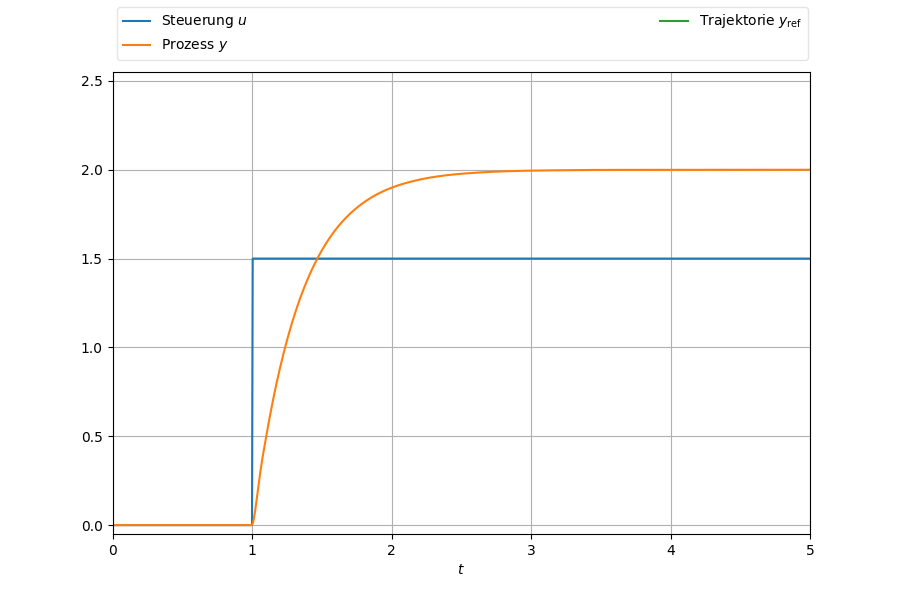

In [7]:
output = widgets.Output()

with output:
    fig, ax1 = plt.subplots(1, 1, figsize=(9, 6), sharex=True, gridspec_kw={'height_ratios': [1]})

plt.subplots_adjust(wspace=0.2, hspace=0.3)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

ax1.set_xlim([0, tSim[-1]]) 
ax1.set_ylim([-0.05, 2.55]) 
ax1.grid() 
ax1.set_xlabel(r"$t$")

uSys, = ax1.plot([], [], label=r'Steuerung $u$')
ySys, = ax1.plot([], [], label=r'Prozess $y$')
yRefSys, = ax1.plot([], [], label=r'Trajektorie $y_{\mathrm{ref}}$')

handlesAx, labelsAx = ax1.get_legend_handles_labels()
fig.legend([handle for i, handle in enumerate(handlesAx)],
           [label for i, label in enumerate(labelsAx)],
           bbox_to_anchor=(0.13, 0.9, 0.7675, .15), loc=3,
           ncol=2, mode="expand", borderaxespad=0., framealpha=0.5)

radioU = widgets.RadioButtons(options=['Sprung', 'Trajektorie'],
                              description='Eingang:',
                              disabled=False)
sliderDt = widgets.FloatSlider(value=3,
                               min=1,
                               max=4,
                               step=1,
                               description='dt')
sliderA = widgets.FloatSlider(value=3,
                              min=1,
                              max=5,
                              step=1,
                              description='a')

def calcSystem(_):
    dt = sliderDt.value
    a = sliderA.value
    
    def prozess(t, x, u, a, b):
        dx = -a * x[0] + b * u(t)
        return dx
    
    if radioU.value == 'Sprung':
        uTraj = lambda t: yd * a / b if t > t0 else 0
    else:
        yr = lambda t: yd * (3 * (t - t0) ** 2 / dt ** 2 - 2 * (t - t0) ** 3 / dt ** 3) if t0 <= t <= t0 + dt else 0 if t < t0 else yd 
        dyr = lambda t: yd * (6 * (t - t0) / dt ** 2 - 6 * (t - t0) ** 2 / dt ** 3) if t0 < t < t0 + dt else 0
        uTraj = lambda t: 1 / b * (dyr(t) + a * yr(t))
    
    res = solve_ivp(prozess,
                    [tSim[0], tSim[-1]],
                    x0,
                    t_eval=tSim, args=(uTraj, a, b))
    
    uSys.set_data(tSim, [uTraj(t) for t in tSim])
    ySys.set_data(tSim, res.y.T[:, 0])
    if radioU.value == 'Sprung':
        yRefSys.set_data([],[])
    else:
        yRefSys.set_data(tSim, [yr(t) for t in tSim])
    fig.canvas.draw()

sliderDt.observe(calcSystem, names='value')
sliderA.observe(calcSystem, names='value')
radioU.observe(calcSystem, names='value')

calcSystem(_)

odeControls = VBox([sliderDt, sliderA])
odeControls.layout = make_box_layout()
inputControls = VBox([HBox([radioU]), output])
inputControls.layout = make_box_layout()

HBox([odeControls, Box([inputControls])])